Project Purposes:

- Data Integrity: Ensure complete, reliable data by applying advanced, ensemble-based imputation techniques.
- Exploratory Insights: Uncover and visualize key data patterns, relationships, and anomalies through robust exploratory data analysis (EDA).
- Analytical Readiness: Prepare the dataset for downstream predictive modeling and decision-making with thorough preprocessing and feature engineering.

### Part 1: Import Libraries and Set Up

**Purpose:**  
- Import all required libraries (e.g., pandas, numpy, matplotlib, seaborn, scikit-learn).
- Suppress unnecessary warnings.
- Set a random seed for reproducibility.

This section establishes the environment needed for data loading, analysis, imputation, and modeling.


In [5]:
# %% [code]
# Import libraries and suppress convergence warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)  # Suppress convergence warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For imputation and modeling
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# For file download in Jupyter
from IPython.display import FileLink

# Set random seed for reproducibility
RANDOM_STATE = 42

print("=== Code execution started ===")


=== Code execution started ===


### Part 2: Data Loading & Initial Exploratory Data Analysis (EDA)

**Purpose:**  
- Load the dataset from `baa.csv` (update the file path as needed).
- Remove columns with less than 20% non-null values.
- Display key dataset properties: shape, head, summary statistics.
- Visualize missing values using a heatmap and explore numeric feature correlations.

This stage provides an initial overview and quality check of the dataset.


Columns retained after filtering (<20% filled removed): ['OSF_ID', 'Maternal_Age', 'Household_Income', 'Maternal_Education', 'Edinburgh_Postnatal_Depression_Scale', 'PROMIS_Anxiety', 'Gestational_Age_At_Birth', 'Delivery_Date(converted to month and year)', 'Birth_Length', 'Birth_Weight', 'Delivery_Mode', 'NICU_Stay', 'Language', 'Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm']
Dataset Shape: (10772, 16)
First 5 rows:


,OSF_ID,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date(converted to month and year),Birth_Length,Birth_Weight,Delivery_Mode,NICU_Stay,Language,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm
0,1,38.3,"$200,000+",Masters degree,9.0,13.0,39.71,Dec-20,49.20,3431.0,Vaginally,No,English,2,3,27
1,2,34.6,"$200,000+",Undergraduate degree,4.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,English,2,33,92
2,3,34.3,"$100,000 -$124,999",Undergraduate degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,French,,,
3,4,28.8,"$100,000 -$124,999",Masters degree,9.0,20.0,38.57,Dec-20,41.00,2534.0,Vaginally,No,French,53,67,54
4,5,36.5,"$40,000-$69,999",Undergraduate degree,14.0,20.0,39.86,Oct-20,53.34,3714.0,Caesarean-section (c-section),No,English,23,32,71



Summary Statistics:


,OSF_ID,Maternal_Age,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Birth_Length,Birth_Weight
count,10772.000000,10661.000000,9598.000000,9566.000000,6734.000000,5480.000000,6078.000000
mean,5386.500000,31.844602,10.194832,18.677713,39.342241,50.502504,3412.175058
std,3109.752884,4.422368,5.505230,6.084313,1.612483,4.445347,538.695046
min,1.000000,17.000000,0.000000,7.000000,24.860000,20.000000,303.000000
25%,2693.750000,28.900000,6.000000,14.000000,38.570000,49.000000,3102.250000
50%,5386.500000,31.800000,10.000000,19.000000,39.570000,50.800000,3431.000000
75%,8079.250000,34.800000,14.000000,23.000000,40.430000,53.030000,3742.000000
max,10772.000000,49.700000,30.000000,35.000000,42.860000,70.000000,5968.000000


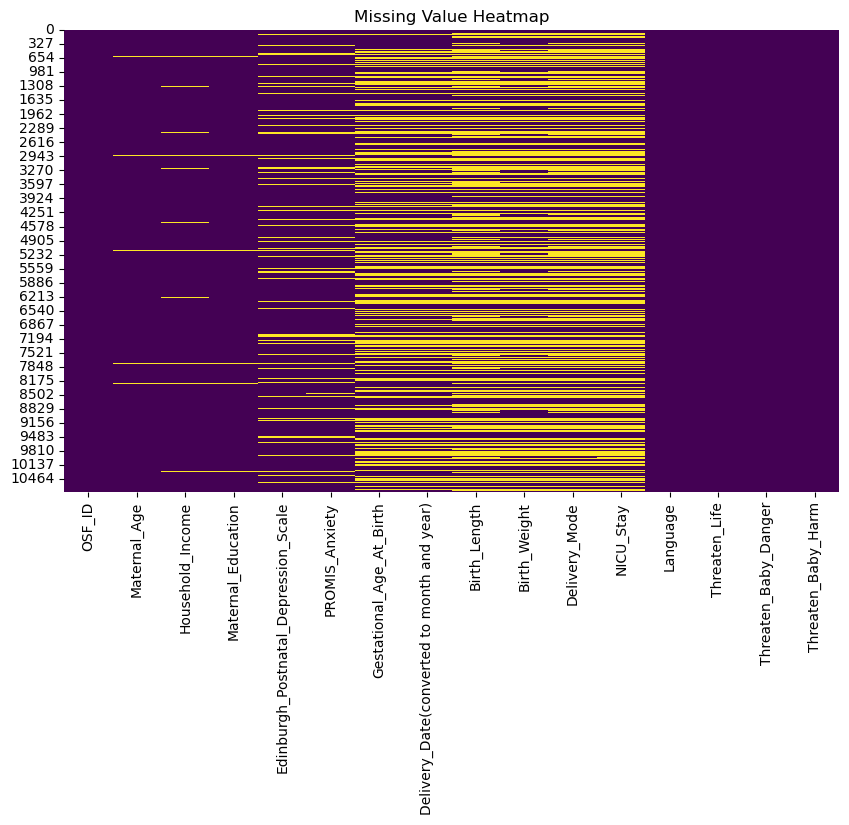

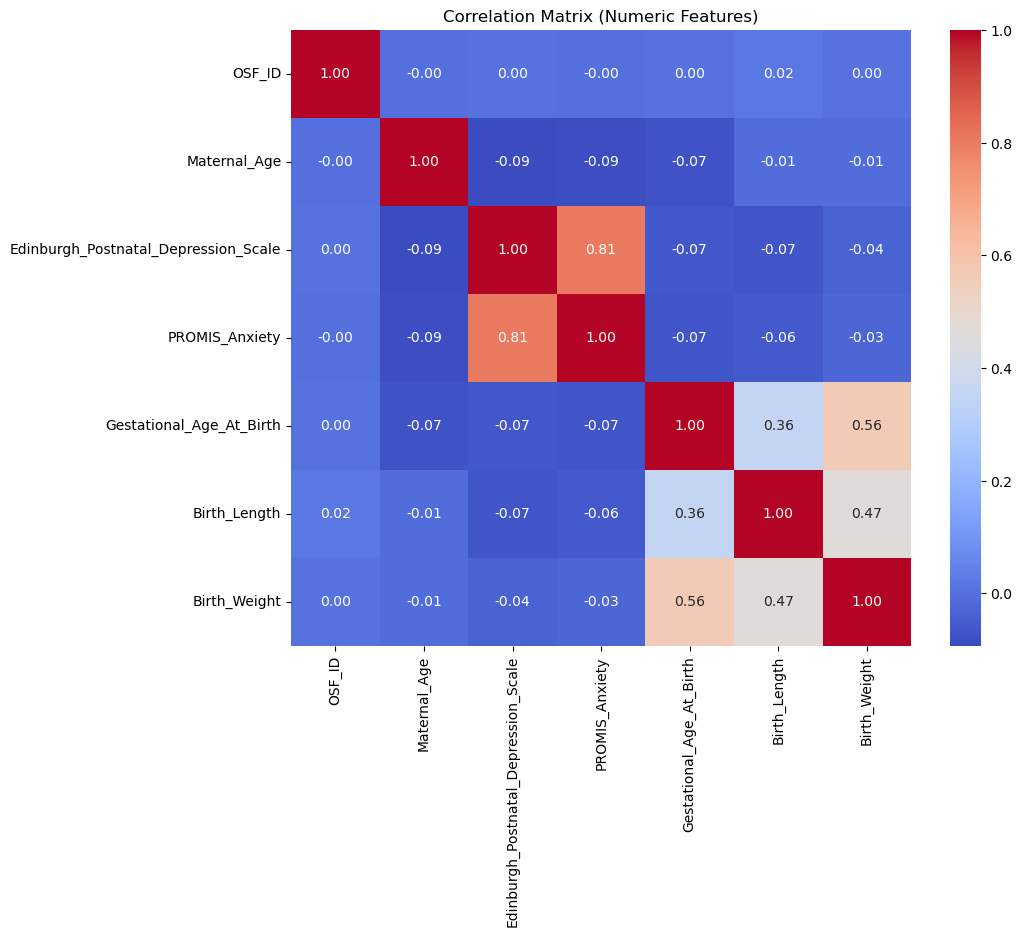

In [6]:
# %% [code]
# === Stage 1: Data Loading & Initial EDA ===
csv_file_path = "C:/Users/SUPARNA BAG/Downloads/baa.csv"  # <-- change to your CSV file path
df = pd.read_csv(csv_file_path)

# Remove columns with less than 20% filled values
threshold = 0.20
df = df.loc[:, df.notnull().mean() >= threshold]
print("Columns retained after filtering (<20% filled removed):", df.columns.tolist())

print("Dataset Shape:", df.shape)
print("First 5 rows:")
display(df.head())

print("\nSummary Statistics:")
display(df.describe())

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Value Heatmap")
plt.show()

numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()


### Part 3: Data Cleaning, Feature Engineering & Feature Selection

**Purpose:**  
- Create a new feature `fill_ratio` representing the proportion of non-missing values per row.
- Split the dataset into three groups based on `fill_ratio`:
  - **Group A:** Fully complete rows.
  - **Group B:** Mostly complete rows (≥80% but not 100%).
  - **Group C:** Incomplete rows (<80% filled).
- Prepare the training data (Groups A and B) and the data that requires imputation (Group C).

This grouping allows for tailored handling of incomplete data in later stages.


In [7]:
# %% [code]
# === Stage 2: Data Cleaning, Feature Engineering, & Feature Selection ===
df['fill_ratio'] = df.notnull().sum(axis=1) / df.shape[1]

# Group rows based on fill_ratio:
group_A = df[df['fill_ratio'] == 1.0].copy()
group_B = df[(df['fill_ratio'] >= 0.8) & (df['fill_ratio'] < 1.0)].copy()
group_C = df[df['fill_ratio'] < 0.8].copy()

print("Group A (100% filled):", group_A.shape)
print("Group B (>=80% filled but not 100%):", group_B.shape)
print("Group C (<80% filled):", group_C.shape)

train_data = pd.concat([group_A, group_B]).drop(columns=["fill_ratio"])
impute_data = group_C.drop(columns=["fill_ratio"])


Group A (100% filled): (5156, 17)
Group B (>=80% filled but not 100%): (774, 17)
Group C (<80% filled): (4842, 17)


### Part 4: Hyperparameter Tuning for Base Models

**Purpose:**  
- Extract numeric features from the training data.
- Use GridSearchCV to tune hyperparameters for:
  - RandomForestRegressor.
  - DecisionTreeRegressor.
- Use BayesianRidge as an imputation model without tuning.

This step helps in selecting the best model parameters to achieve optimal imputation performance.


In [9]:
# %% [code]
# === Stage 3: Hyperparameter Tuning for Base Models ===
train_numeric = train_data.select_dtypes(include=[np.number])

rf_params = {"n_estimators": [50, 100], "max_depth": [5, 7, 10]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE),
                       rf_params,
                       scoring="neg_mean_squared_error",
                       cv=3)
rf_grid.fit(train_numeric, train_numeric.iloc[:, 0])
best_rf = rf_grid.best_estimator_
print("Best parameters for RandomForestRegressor:", rf_grid.best_params_)

dt_params = {"max_depth": [5, 7, 10, None], "min_samples_split": [2, 5]}
dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE),
                       dt_params,
                       scoring="neg_mean_squared_error",
                       cv=3)
dt_grid.fit(train_numeric, train_numeric.iloc[:, 0])
best_dt = dt_grid.best_estimator_
print("Best parameters for DecisionTreeRegressor:", dt_grid.best_params_)

# BayesianRidge is used as is.


Best parameters for RandomForestRegressor: {'max_depth': 10, 'n_estimators': 50}
Best parameters for DecisionTreeRegressor: {'max_depth': 10, 'min_samples_split': 5}


### Part 5: Modeling for Imputation & Evaluation (Stage 1)

**Purpose:**  
- Create iterative imputers for each of the three models: RandomForest, DecisionTree, and BayesianRidge.
- Fit the imputers on complete numeric training data.
- Define and use an evaluation function that masks a fraction of the data and computes RMSE.
- Generate an ensemble imputed dataset for numeric features in Group C using weights inversely proportional to each model’s RMSE.

This step produces an imputed version of the numeric data for incomplete rows.


In [12]:
# === Stage 4: Modeling for Imputation & Evaluation (Stage 1) ===
imputer_rf = IterativeImputer(estimator=best_rf, random_state=RANDOM_STATE, max_iter=20)
imputer_dt = IterativeImputer(estimator=best_dt, random_state=RANDOM_STATE, max_iter=20)
imputer_br = IterativeImputer(estimator=BayesianRidge(), random_state=RANDOM_STATE, max_iter=20)

imputer_rf.fit(train_numeric)
imputer_dt.fit(train_numeric)
imputer_br.fit(train_numeric)

def evaluate_imputer(imputer, data, missing_frac=0.1):
    complete_data = data.dropna()  
    data_mask = complete_data.copy()
    mask = np.random.rand(*complete_data.shape) < missing_frac
    data_mask[mask] = np.nan
    imputed = imputer.transform(data_mask)
    mse = mean_squared_error(complete_data.values[mask], imputed[mask])
    rmse = np.sqrt(mse)
    return rmse

complete_train_numeric = train_numeric.dropna()
rmse_rf = evaluate_imputer(imputer_rf, complete_train_numeric)
rmse_dt = evaluate_imputer(imputer_dt, complete_train_numeric)
rmse_br = evaluate_imputer(imputer_br, complete_train_numeric)

print("\nStage 1 Evaluation (RMSE):")
print("RandomForestRegressor Imputer:", rmse_rf)
print("DecisionTreeRegressor Imputer:", rmse_dt)
print("BayesianRidge Imputer:", rmse_br)

impute_numeric = impute_data.select_dtypes(include=[np.number])
if impute_numeric.shape[0] == 0:
    print("No numeric logs available for imputation in Group C.")
    final_imputed_numeric = pd.DataFrame()
else:
    print("Imputing missing values for numeric columns of Group C...")
    imputed_rf = imputer_rf.transform(impute_numeric)
    imputed_dt = imputer_dt.transform(impute_numeric)
    imputed_br = imputer_br.transform(impute_numeric)

    w_rf = 1 / rmse_rf
    w_dt = 1 / rmse_dt
    w_br = 1 / rmse_br
    sum_weights = w_rf + w_dt + w_br
    w_rf /= sum_weights
    w_dt /= sum_weights
    w_br /= sum_weights

    print("\nEnsemble Weights:")
    print("RandomForestRegressor weight:", w_rf)
    print("DecisionTreeRegressor weight:", w_dt)
    print("BayesianRidge weight:", w_br)

    imputed_ensemble = (w_rf * imputed_rf) + (w_dt * imputed_dt) + (w_br * imputed_br)
    final_imputed_numeric = pd.DataFrame(imputed_ensemble, columns=impute_numeric.columns, index=impute_data.index)



Stage 1 Evaluation (RMSE):
RandomForestRegressor Imputer: 1098.4187834288903
DecisionTreeRegressor Imputer: 1079.7057725723325
BayesianRidge Imputer: 1261.0278916290613
Imputing missing values for numeric columns of Group C...

Ensemble Weights:
RandomForestRegressor weight: 0.34621460173745
DecisionTreeRegressor weight: 0.3522150490496622
BayesianRidge weight: 0.3015703492128877


### Part 6: Augmented Training Using Incomplete Data (Stage 2)

**Purpose:**  
- Augment the training dataset by concatenating the original complete numeric data with the ensemble imputed values from incomplete records.
- Re-fit the iterative imputers on this augmented dataset.
- Re-impute the numeric columns of Group C to obtain a final, refined imputed dataset.

This re-training helps to further refine the imputation using more data.


In [13]:
# %% [code]
# === Stage 5: Augmented Training Using Incomplete Data (Stage 2) ===
if impute_numeric.shape[0] == 0:
    print("Skipping augmented training as there are no numeric incomplete logs.")
    final_imputed_numeric_final = final_imputed_numeric
else:
    augmented_train_data = pd.concat([train_numeric, final_imputed_numeric], axis=0)
    imputer_rf.fit(augmented_train_data)
    imputer_dt.fit(augmented_train_data)
    imputer_br.fit(augmented_train_data)

    imputed_rf_final = imputer_rf.transform(impute_numeric)
    imputed_dt_final = imputer_dt.transform(impute_numeric)
    imputed_br_final = imputer_br.transform(impute_numeric)

    imputed_ensemble_final = (w_rf * imputed_rf_final) + (w_dt * imputed_dt_final) + (w_br * imputed_br_final)
    final_imputed_numeric_final = pd.DataFrame(imputed_ensemble_final, columns=impute_numeric.columns, index=impute_data.index)
    print("Augmented training and final numeric imputation completed.")


Augmented training and final numeric imputation completed.


### Part 7: Imputing Non-Numeric Columns for Group C

**Purpose:**  
- For non-numeric (categorical) columns in the incomplete group, fill in missing values.
- Use the mode (most frequent value) for imputation; if no mode exists, use "Unknown".

This ensures that categorical data is also complete and ready for any further analysis.


In [14]:
# %% [code]
# === Stage 6: Imputing Non-Numeric Columns for Group C ===
non_numeric = impute_data.select_dtypes(exclude=[np.number])
if non_numeric.shape[0] > 0:
    non_numeric_imputed = non_numeric.copy()
    for col in non_numeric.columns:
        if non_numeric[col].mode().empty:
            fill_val = "Unknown"
        else:
            fill_val = non_numeric[col].mode().iloc[0]
        non_numeric_imputed[col] = non_numeric_imputed[col].fillna(fill_val)
    print("Non-numeric columns imputed using mode.")
else:
    non_numeric_imputed = pd.DataFrame(index=impute_data.index)
    print("No non-numeric columns found.")


Non-numeric columns imputed using mode.


### Part 8: Creating the Final Complete Dataset for Group C

**Purpose:**  
- Combine the final imputed numeric data with the imputed non-numeric data.
- Reorder the columns to match the original structure of Group C.

The result is a fully imputed, complete dataset for the incomplete portion of the data.


In [15]:
# %% [code]
# === Stage 7: Creating Final Complete Dataset for Group C ===
if final_imputed_numeric_final.empty:
    final_complete_df = pd.DataFrame()
else:
    final_complete_df = pd.concat([final_imputed_numeric_final, non_numeric_imputed], axis=1)
    final_complete_df = final_complete_df[impute_data.columns]
    print("Final complete dataset for Group C created with all missing values filled.")


Final complete dataset for Group C created with all missing values filled.


### Part 9: Exporting the Final Imputed Dataset for Group C

**Purpose:**  
- Export the final, imputed dataset to a CSV file.
- Use a semicolon delimiter, format numeric values to two decimal places, and apply UTF-8 BOM encoding (to ensure Excel compatibility).

This final step saves your cleaned and imputed data for further analysis or reporting.


In [17]:
# %% [code]
# === Stage 8: Exporting the Final Imputed Dataset for Group C ===
if final_complete_df.empty:
    print("No imputed logs to export.")
else:
    # Save as semicolon-delimited, 2 decimal places for floats, and UTF-8 BOM encoding
    final_csv_path = "final_imputed_data_0.csv"
    final_complete_df.to_csv(
        final_csv_path,
        index=False,
        sep=';',              # Use semicolon as delimiter
        float_format='%.2f',  # Two decimal places for numeric columns
        encoding='utf-8-sig'  # Helps Excel detect UTF-8 encoding properly
    )
    print(f"Final imputed CSV file has been saved as '{final_csv_path}'.")
    display(FileLink(final_csv_path))

print("\n=== Code execution completed ===")


Final imputed CSV file has been saved as 'final_imputed_data_0.csv'.


C:\Users\SUPARNA BAG\final_imputed_data_0.csv


=== Code execution completed ===


### Additional Part A1: Extended Descriptive Statistics

**Purpose:**  
- Compute and display additional descriptive statistics for all numeric columns.
- This includes variance, skewness, and kurtosis, which provide deeper insight into the distribution of each feature.

This helps you understand the spread and shape of your data's distributions.


In [21]:
if not df.empty:
    # Select only numeric columns for descriptive statistics
    df_numeric = df.select_dtypes(include=[np.number])
    
    if df_numeric.empty:
        print("No numeric columns available for extended descriptive statistics.")
    else:
        desc_stats = df_numeric.describe().T
        desc_stats["variance"] = df_numeric.var()
        desc_stats["skewness"] = df_numeric.skew()
        desc_stats["kurtosis"] = df_numeric.kurtosis()
        print("Extended Descriptive Statistics:")
        display(desc_stats)
else:
    print("Dataset is empty.")


Extended Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max,variance,skewness,kurtosis
OSF_ID,10772.0,5386.500000,3109.752884,1.0000,2693.750,5386.500,8079.25,10772.00,9.670563e+06,0.000000,-1.200000
Maternal_Age,10661.0,31.844602,4.422368,17.0000,28.900,31.800,34.80,49.70,1.955734e+01,0.000671,0.088400
Edinburgh_Postnatal_Depression_Scale,9598.0,10.194832,5.505230,0.0000,6.000,10.000,14.00,30.00,3.030756e+01,0.301105,-0.333230
PROMIS_Anxiety,9566.0,18.677713,6.084313,7.0000,14.000,19.000,23.00,35.00,3.701886e+01,0.036227,-0.693554
Gestational_Age_At_Birth,6734.0,39.342241,1.612483,24.8600,38.570,39.570,40.43,42.86,2.600101e+00,-1.946987,9.094583
Birth_Length,5480.0,50.502504,4.445347,20.0000,49.000,50.800,53.03,70.00,1.976111e+01,-2.323326,11.110972
Birth_Weight,6078.0,3412.175058,538.695046,303.0000,3102.250,3431.000,3742.00,5968.00,2.901924e+05,-0.586700,2.700466
fill_ratio,10772.0,0.817496,0.189378,0.3125,0.625,0.875,1.00,1.00,3.586387e-02,-0.278415,-1.584527


### Additional Part A2: Outlier Detection and Visualization

**Purpose:**  
- Visualize outliers in the dataset using boxplots for each numeric feature.
- This helps you identify extreme values that might affect further analysis.

A visual inspection can flag potential anomalies in your data.


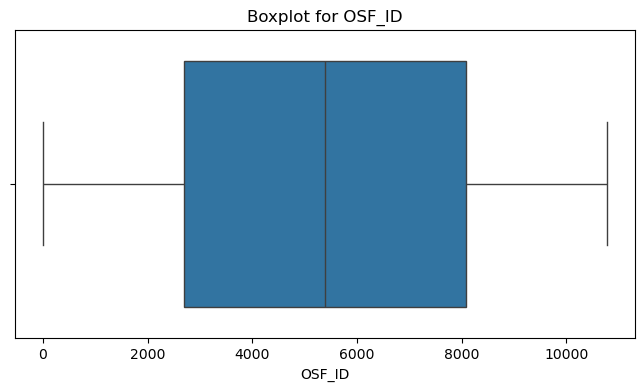

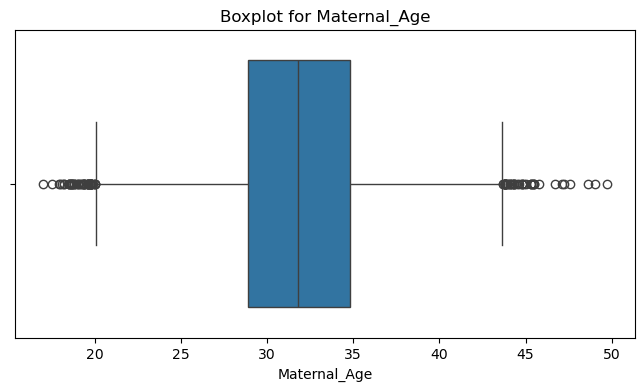

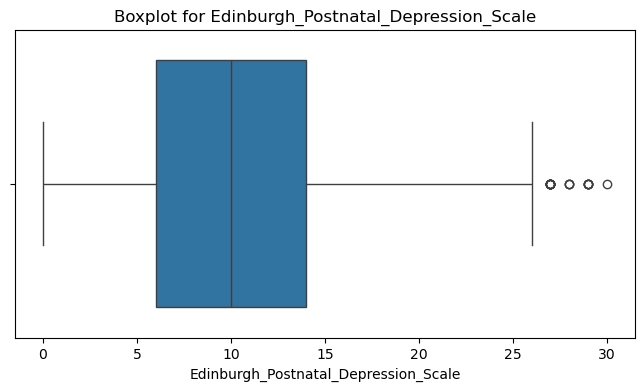

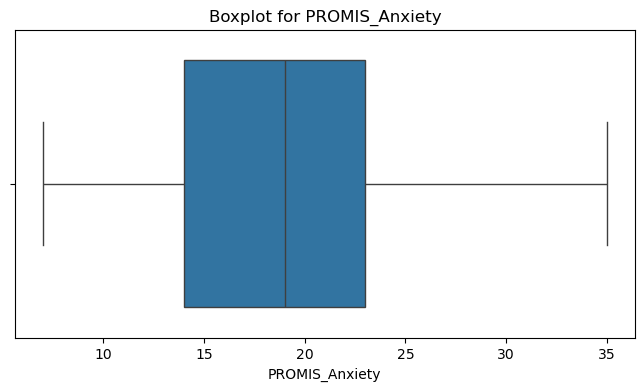

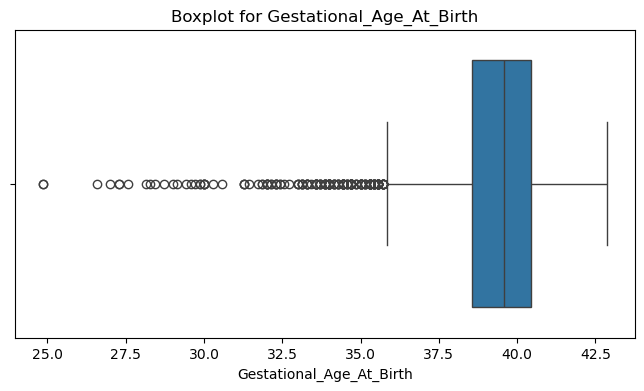

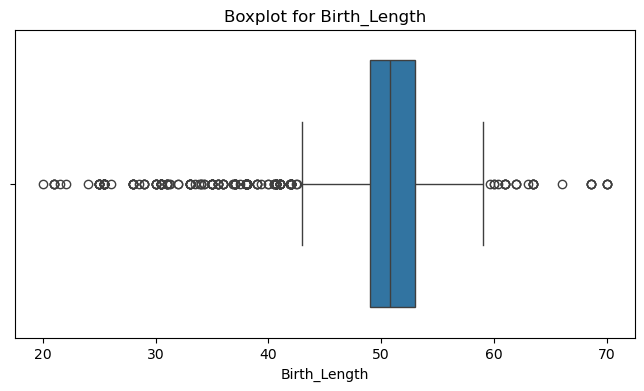

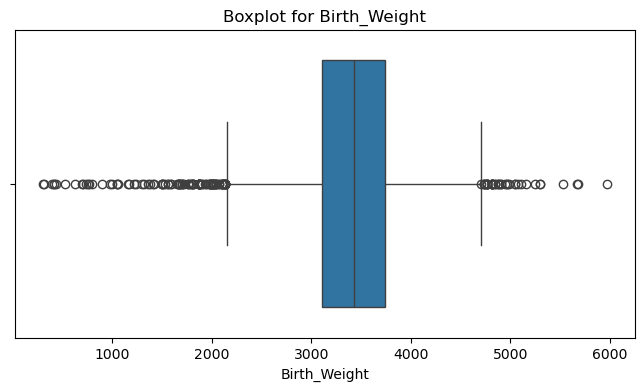

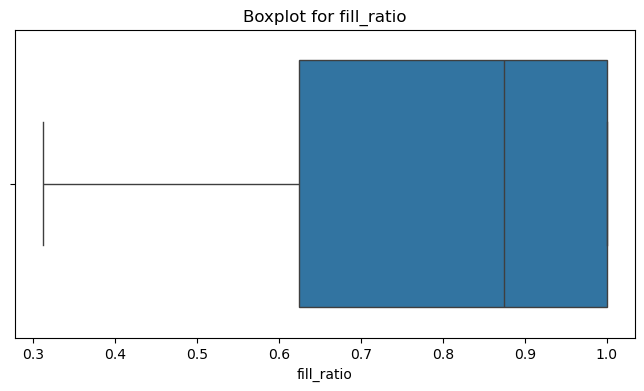

In [22]:
# %% [code]
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    for col in num_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot for {col}")
        plt.xlabel(col)
        plt.show()
else:
    print("No numeric columns available for outlier detection.")


### Additional Part A3: Advanced Missing Data Visualization

**Purpose:**  
- Use the `missingno` library to generate detailed visualizations (matrix and heatmap) of missing data.
- Uncover any systematic missingness patterns in your dataset.

This aids in understanding the structure of missing data.


Missing Data Matrix:


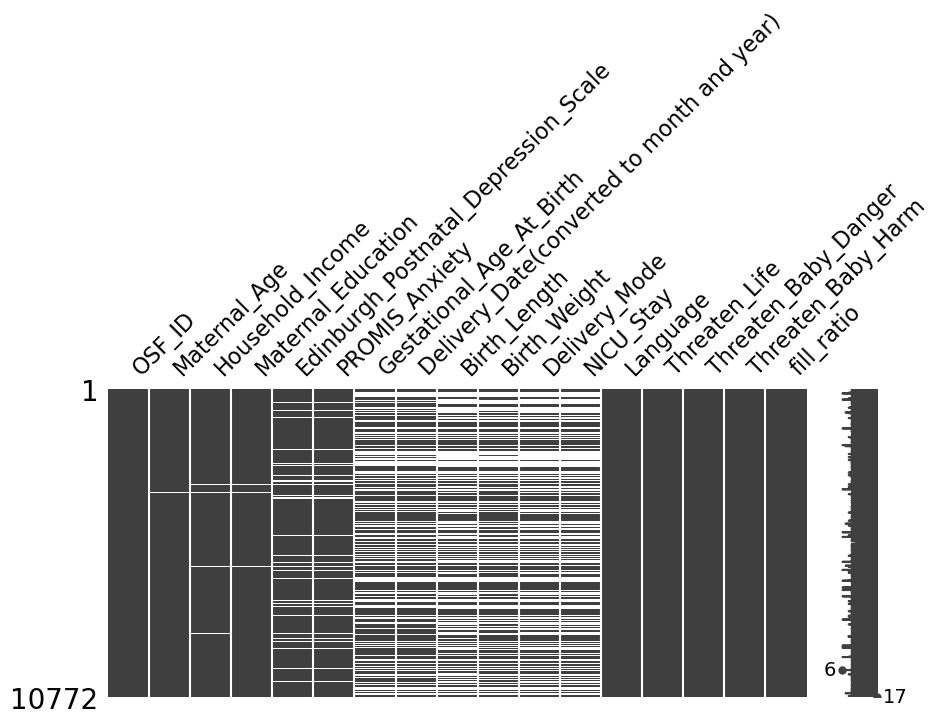

Missing Data Heatmap:


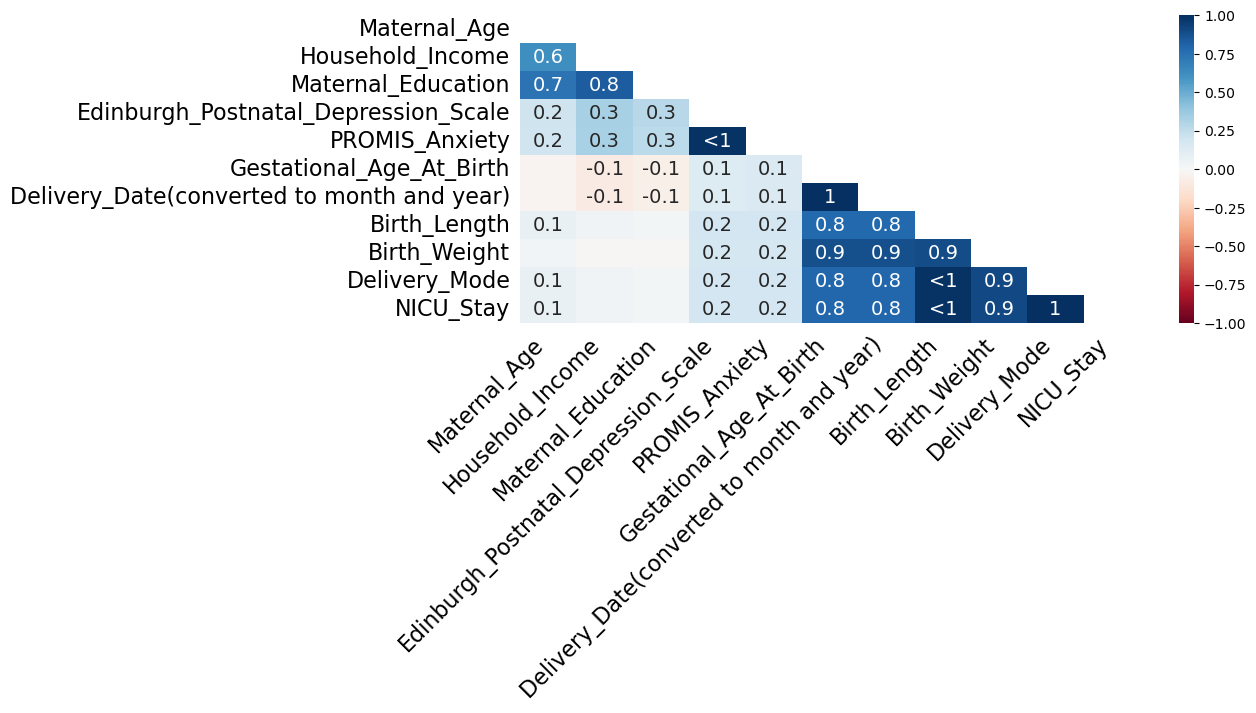

In [25]:
# %% [code]
try:
    import missingno as msno
except ImportError:
    print("missingno not installed. Run: pip install missingno")

print("Missing Data Matrix:")
msno.matrix(df, figsize=(10, 4))
plt.show()

print("Missing Data Heatmap:")
msno.heatmap(df, figsize=(10, 4))
plt.show()


### Additional Part A4: Generic Correlation Analysis

**Purpose:**  
- Calculate and visualize the correlation matrix for numeric features.
- Identify relationships between variables in your dataset.

This analysis helps you understand inter-feature dependencies.


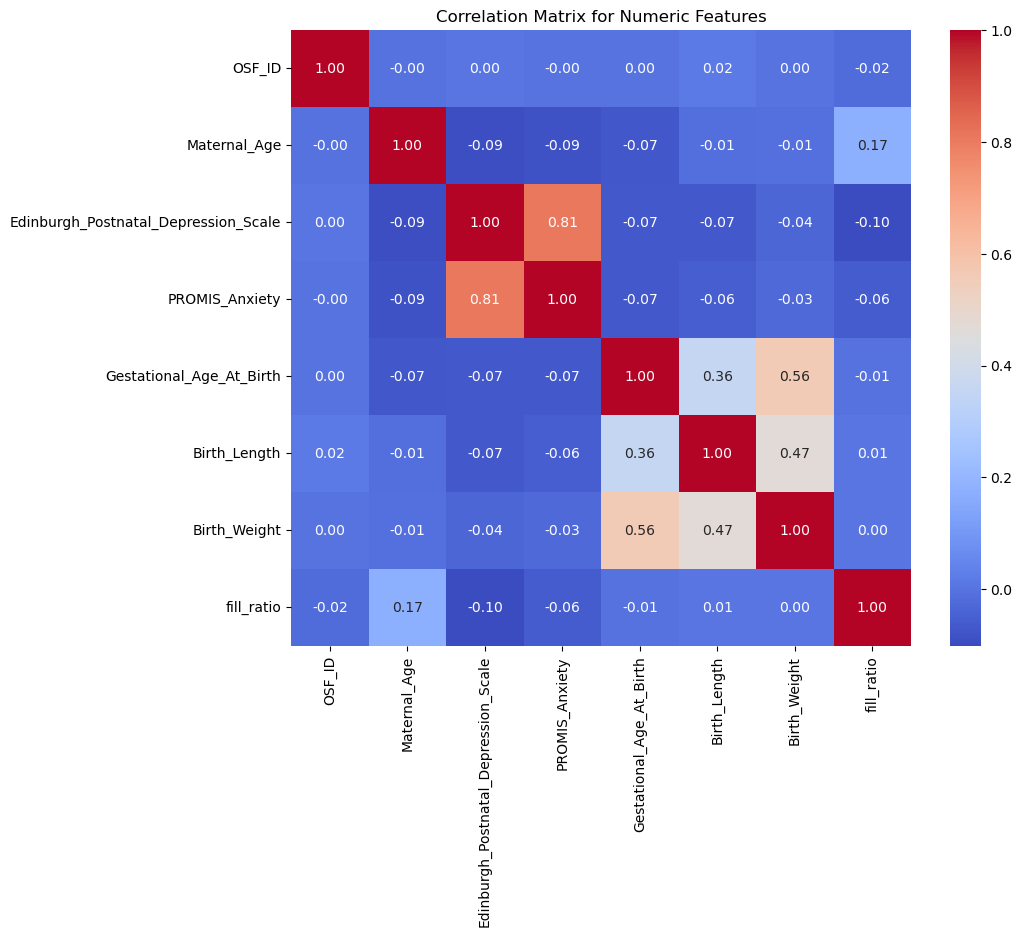

In [26]:
# %% [code]
if not df.empty:
    corr_matrix = df.select_dtypes(include=[np.number]).corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Matrix for Numeric Features")
    plt.show()
else:
    print("Dataset is empty. Cannot compute correlation matrix.")


### Additional Part A5: Basic Feature Engineering (Generic Ratios)

**Purpose:**  
- Create a new feature based on the ratio of the first two numeric columns (if available).
- This generic ratio may reveal useful relationships in the data.

This step offers a simple yet potentially insightful derived metric.


In [27]:
# %% [code]
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    ratio_feature = df[num_cols[0]] / (df[num_cols[1]] + 1e-6)  # add small constant to avoid division by zero
    new_feature_name = "ratio_" + num_cols[0] + "_to_" + num_cols[1]
    df[new_feature_name] = ratio_feature
    print(f"Created feature '{new_feature_name}'")
    display(df[[num_cols[0], num_cols[1], new_feature_name]].head())
else:
    print("Not enough numeric columns to create a ratio feature.")


Created feature 'ratio_OSF_ID_to_Maternal_Age'


,OSF_ID,Maternal_Age,ratio_OSF_ID_to_Maternal_Age
0,1,38.3,0.026110
1,2,34.6,0.057803
2,3,34.3,0.087464
3,4,28.8,0.138889
4,5,36.5,0.136986


### Additional Part A6: K-Means Clustering Analysis

**Purpose:**  
- Apply K-Means clustering on numeric features to identify natural groupings in the data.
- Visualize the clusters using a scatter plot based on the first numeric feature.

This analysis can reveal underlying patterns in the dataset.


K-Means Clustering completed. Cluster counts:
Cluster
2    1785
1    1705
0    1683
Name: count, dtype: int64


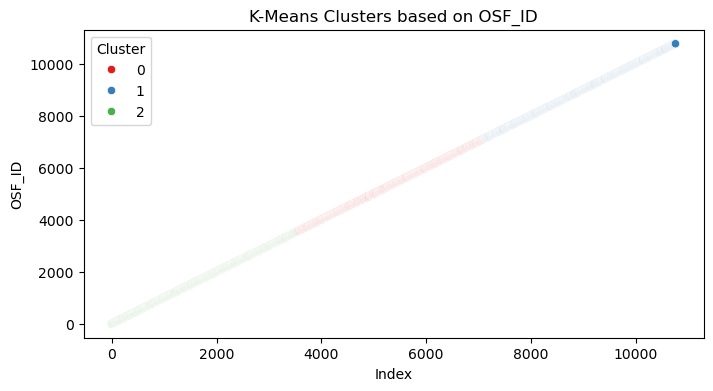

In [28]:
# %% [code]
from sklearn.cluster import KMeans

if num_cols:
    numeric_data = df[num_cols].dropna()
    if not numeric_data.empty:
        kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE)
        clusters = kmeans.fit_predict(numeric_data)
        numeric_data["Cluster"] = clusters
        print("K-Means Clustering completed. Cluster counts:")
        print(numeric_data["Cluster"].value_counts())
        
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x=numeric_data.index, y=numeric_data[num_cols[0]], hue="Cluster", data=numeric_data, palette="Set1")
        plt.title("K-Means Clusters based on " + num_cols[0])
        plt.xlabel("Index")
        plt.ylabel(num_cols[0])
        plt.show()
    else:
        print("Not enough numeric data for clustering.")
else:
    print("No numeric columns available for clustering analysis.")


### Additional Part A7: PCA Dimensionality Reduction

**Purpose:**  
- Apply Principal Component Analysis (PCA) on the numeric data to reduce dimensionality.
- Plot the cumulative explained variance to determine the number of components needed to capture most variability.

This helps you understand the intrinsic structure of your dataset.


Number of PCA components selected: 6
Explained variance ratio per component:
[0.25144217 0.21689117 0.12725716 0.1239899  0.12270981 0.08188087]


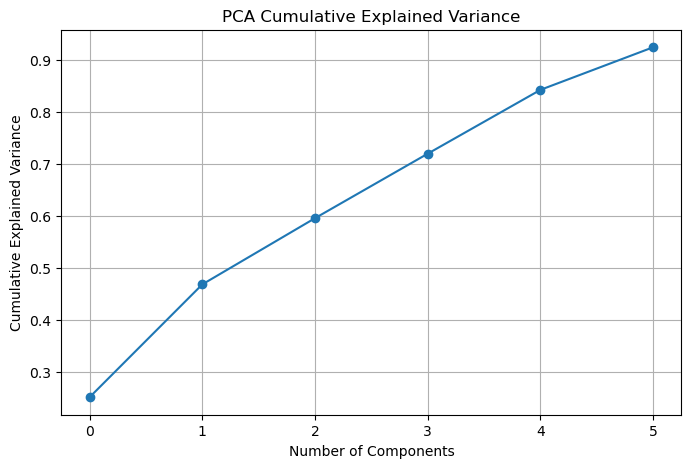

In [29]:
# %% [code]
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

if num_cols:
    numeric_data = df[num_cols].dropna()
    scaler_pca = StandardScaler()
    scaled_data = scaler_pca.fit_transform(numeric_data)
    
    pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
    pca_components = pca.fit_transform(scaled_data)
    
    print("Number of PCA components selected:", pca.n_components_)
    print("Explained variance ratio per component:")
    print(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA Cumulative Explained Variance")
    plt.grid(True)
    plt.show()
else:
    print("No numeric columns available for PCA.")


### Additional Part A8: K-Fold Cross-Validation for Imputation

**Purpose:**  
- Evaluate the performance of the imputation models using 5-fold cross-validation.
- Report the average RMSE for each imputer across folds.

This provides a robust measure of imputation performance.


In [30]:
# %% [code]
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def cross_val_imputation(imputer, data):
    rmses = []
    for train_idx, test_idx in kf.split(data):
        train_cv = data.iloc[train_idx]
        test_cv = data.iloc[test_idx].copy()
        mask = np.random.rand(*test_cv.shape) < 0.1
        test_cv_masked = test_cv.copy()
        test_cv_masked[mask] = np.nan
        
        imputed = imputer.transform(test_cv_masked)
        mse = mean_squared_error(test_cv.values[mask], imputed[mask])
        rmses.append(np.sqrt(mse))
    return np.mean(rmses)

if not train_numeric.empty:
    cv_rmse_rf = cross_val_imputation(imputer_rf, train_numeric.dropna())
    cv_rmse_dt = cross_val_imputation(imputer_dt, train_numeric.dropna())
    cv_rmse_br = cross_val_imputation(imputer_br, train_numeric.dropna())
    
    print("K-Fold CV RMSE - RandomForestImputer:", cv_rmse_rf)
    print("K-Fold CV RMSE - DecisionTreeImputer:", cv_rmse_dt)
    print("K-Fold CV RMSE - BayesianRidgeImputer:", cv_rmse_br)
else:
    print("Training numeric data is empty. Cannot perform cross-validation.")


K-Fold CV RMSE - RandomForestImputer: 1113.640109908676
K-Fold CV RMSE - DecisionTreeImputer: 1129.8267067464521
K-Fold CV RMSE - BayesianRidgeImputer: 1192.6680301689998


### Additional Part A9: Save Intermediate Outputs

**Purpose:**  
- Save key intermediate outputs (such as the final complete imputed dataset and the correlation matrix) to files.
- This ensures you can reuse these results later without re-running the entire pipeline.

Saving intermediate outputs aids in reproducibility.


In [31]:
# %% [code]
if not final_complete_df.empty:
    final_complete_df.to_csv("final_complete_imputed_data.csv", index=False, sep=';', float_format='%.2f', encoding='utf-8-sig')
    print("Final complete imputed dataset saved as 'final_complete_imputed_data.csv'.")
else:
    print("Final complete dataset is empty; nothing to save.")

if not df.empty:
    corr_matrix = df.select_dtypes(include=[np.number]).corr()
    corr_matrix.to_csv("correlation_matrix.csv")
    print("Correlation matrix saved as 'correlation_matrix.csv'.")


Final complete imputed dataset saved as 'final_complete_imputed_data.csv'.
Correlation matrix saved as 'correlation_matrix.csv'.


### Additional Part A10: Anomaly Detection Using Isolation Forest

**Purpose:**  
- Use the Isolation Forest algorithm to detect anomalies in the numeric data.
- Visualize anomaly scores to identify potential outlier observations.

This helps in flagging data points that might be anomalies.


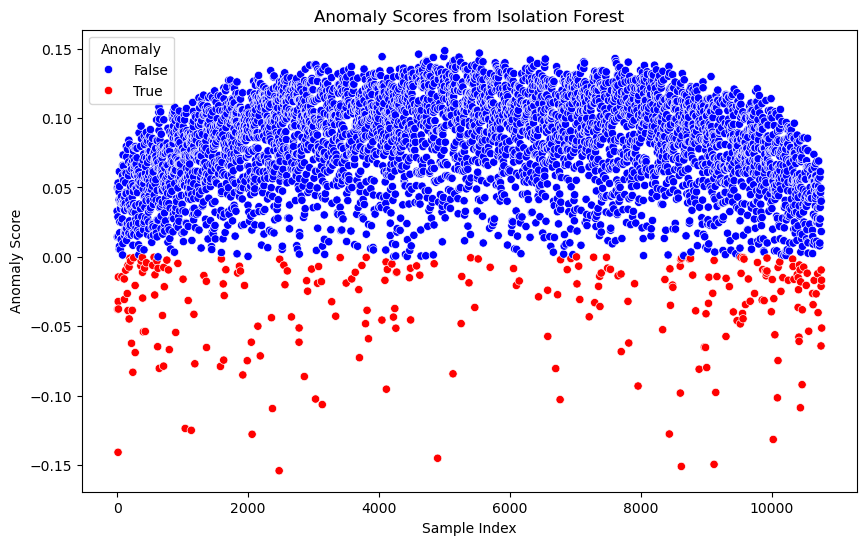

In [32]:
# %% [code]
from sklearn.ensemble import IsolationForest

numeric_data = df.select_dtypes(include=[np.number]).dropna()
if not numeric_data.empty:
    iso_forest = IsolationForest(contamination=0.05, random_state=RANDOM_STATE)
    preds = iso_forest.fit_predict(numeric_data)
    anomaly_scores = iso_forest.decision_function(numeric_data)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=numeric_data.index, y=anomaly_scores, hue=(preds == -1), palette={True: 'red', False: 'blue'})
    plt.title("Anomaly Scores from Isolation Forest")
    plt.xlabel("Sample Index")
    plt.ylabel("Anomaly Score")
    plt.legend(title="Anomaly")
    plt.show()
else:
    print("No numeric data available for anomaly detection.")


### Additional Part A11: t-SNE Visualization for High-Dimensional Data

**Purpose:**  
- Use t-SNE to reduce high-dimensional numeric data to two dimensions.
- Visualize the results in a scatter plot, optionally colored by a categorical variable if available.

This can reveal underlying patterns in complex data.


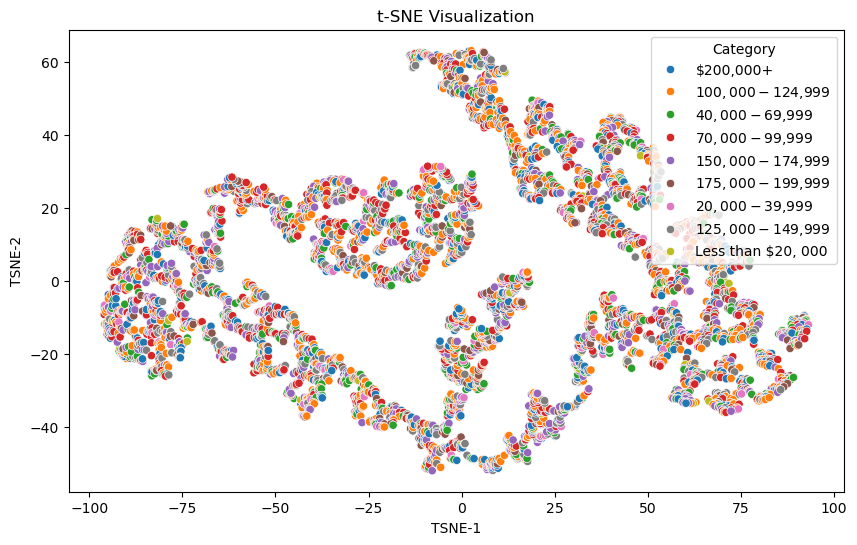

In [33]:
# %% [code]
from sklearn.manifold import TSNE

numeric_data = df.select_dtypes(include=[np.number]).dropna()
if not numeric_data.empty:
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
    tsne_results = tsne.fit_transform(numeric_data)
    
    tsne_df = pd.DataFrame(tsne_results, columns=["TSNE-1", "TSNE-2"], index=numeric_data.index)
    # If a categorical variable exists, use it; otherwise, show single-color scatter
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    if cat_cols:
        tsne_df["Category"] = df[cat_cols[0]].loc[numeric_data.index]
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x="TSNE-1", y="TSNE-2", hue="Category", data=tsne_df, palette="tab10")
    else:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x="TSNE-1", y="TSNE-2", data=tsne_df, color="blue")
    plt.title("t-SNE Visualization")
    plt.show()
else:
    print("No numeric data available for t-SNE visualization.")


### Additional Part A12: DBSCAN Clustering

**Purpose:**  
- Apply DBSCAN clustering on numeric features to detect clusters and noise.
- Visualize the clustering results with a scatter plot.

DBSCAN can detect clusters of arbitrary shape and identify noise.


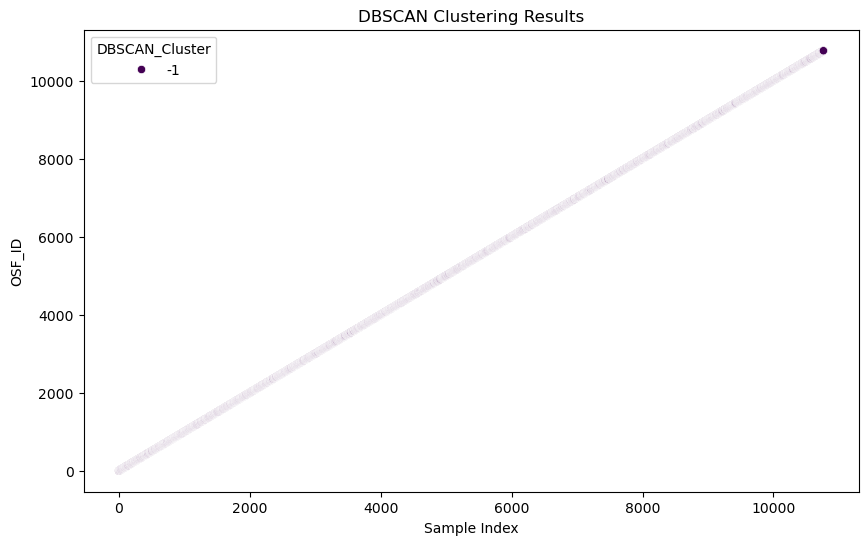

In [34]:
# %% [code]
from sklearn.cluster import DBSCAN

numeric_data = df.select_dtypes(include=[np.number]).dropna()
if not numeric_data.empty:
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters_dbscan = dbscan.fit_predict(numeric_data)
    numeric_data["DBSCAN_Cluster"] = clusters_dbscan
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=numeric_data.index, y=numeric_data.iloc[:, 0], hue="DBSCAN_Cluster", data=numeric_data, palette="viridis")
    plt.title("DBSCAN Clustering Results")
    plt.xlabel("Sample Index")
    plt.ylabel(numeric_data.columns[0])
    plt.show()
else:
    print("No numeric data available for DBSCAN clustering.")


### Additional Part A13: Forecasting Analysis (If Time Series Exists)

**Purpose:**  
- If a date column exists, perform a simple time series forecasting using ARIMA.
- Plot historical data along with forecasts.

This is useful if your dataset contains a time component.


Could not infer frequency. Setting default frequency to 'ME'.


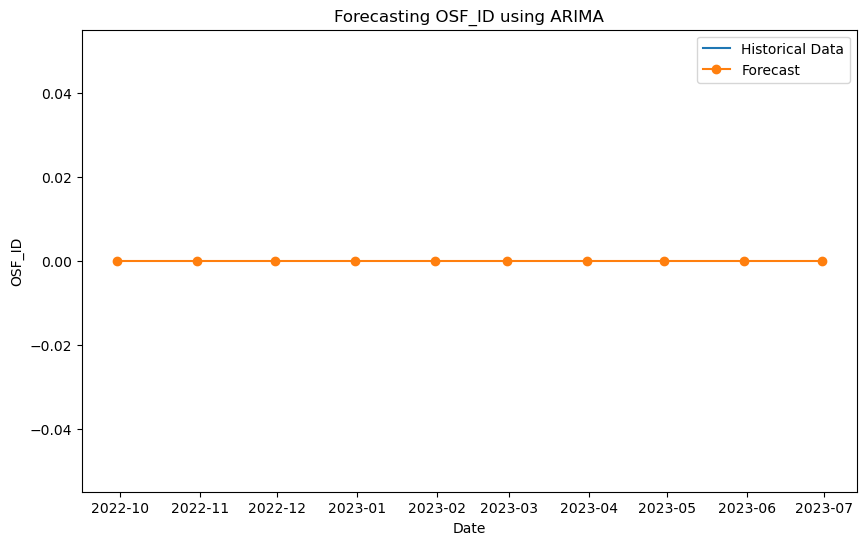

In [40]:
import warnings
try:
    from statsmodels.tsa.arima.model import ARIMA
except ImportError:
    print("statsmodels not installed. Run: pip install statsmodels")

# Identify date columns and ensure there is at least one numeric column
date_cols = [col for col in df.columns if "date" in col.lower()]
if date_cols and num_cols:
    date_col = date_cols[0]
    try:
        # Create a copy to avoid SettingWithCopyWarning
        df = df.copy()

        # Parse dates using a specified format (adjust if needed)
        df[date_col] = pd.to_datetime(df[date_col], format="%b-%y", errors='coerce')
        # Drop rows where date conversion failed
        df = df.dropna(subset=[date_col])
        
        # Sort values by the date column
        df = df.sort_values(by=date_col)
        
        # Use the first numeric column for forecasting
        ts = df.set_index(date_col)[num_cols[0]].dropna()

        # Remove duplicate date indices to avoid reindexing issues
        ts = ts[~ts.index.duplicated(keep='first')]

        # Infer the frequency; if not found, set default frequency to 'ME' (month-end)
        freq = pd.infer_freq(ts.index)
        if freq is None:
            print("Could not infer frequency. Setting default frequency to 'ME'.")
            ts = ts.asfreq('ME')
        else:
            ts = ts.asfreq(freq)
        
        # Check if there are enough observations for robust estimation
        min_obs = 10  # Adjust this threshold as needed
        if len(ts) < min_obs:
            print(f"Warning: Only {len(ts)} observations available. ARIMA starting parameters may be unreliable.")
        
        # Suppress the ARIMA warning about too few observations for starting parameters
        warnings.filterwarnings("ignore", message="Too few observations to estimate starting parameters", category=UserWarning)

        # Fit the ARIMA model
        model = ARIMA(ts, order=(1, 1, 1))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=10)

        plt.figure(figsize=(10, 6))
        plt.plot(ts, label="Historical Data")
        plt.plot(forecast, label="Forecast", marker='o')
        plt.title(f"Forecasting {num_cols[0]} using ARIMA")
        plt.xlabel("Date")
        plt.ylabel(num_cols[0])
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"Error in forecasting analysis: {e}")
else:
    print("No date column or numeric column available for forecasting analysis.")


### Additional Part A14: SHAP Analysis for Model Explanation

**Purpose:**  
- Use SHAP (SHapley Additive exPlanations) to interpret the predictions of your classification model.
- This example uses the previously built RandomForestClassifier (if available) to explain feature contributions.

This aids in understanding which features most influence model predictions.


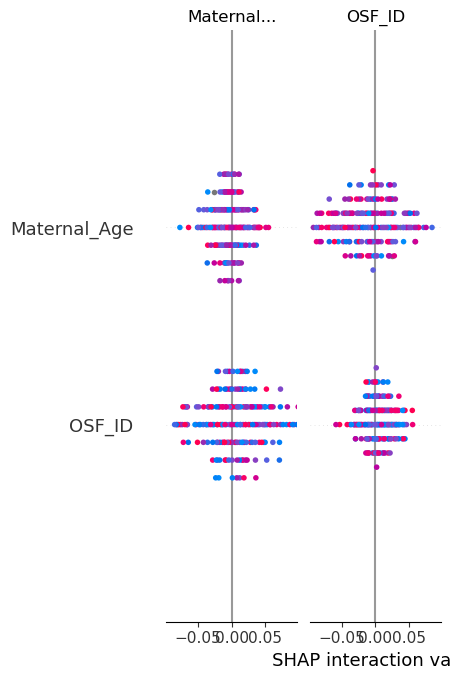

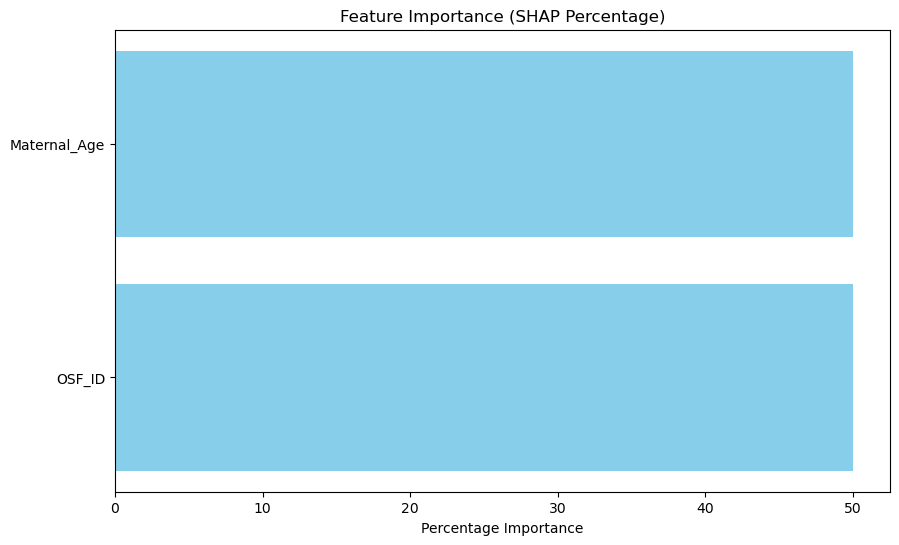

In [63]:
try:
    import shap
except ImportError:
    print("SHAP not installed. Run: pip install shap")

# Create dummy binary target if not present
if "pass_fail_enc" not in df.columns:
    print("Column 'pass_fail_enc' not found. Creating a dummy binary target.")
    df["pass_fail_enc"] = np.random.randint(0, 2, size=len(df))

# Select only numeric features to avoid conversion issues (e.g., currency strings)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [col for col in numeric_cols if col != "pass_fail_enc"]

if features:
    X = df[features]
    y = df["pass_fail_enc"]

    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Compute SHAP values using the new API with a subset of test data
    explainer = shap.Explainer(clf, X_train)
    subset_size = 200
    subset_X_test = X_test.iloc[:subset_size] if len(X_test) > subset_size else X_test
    subset_shap_values = explainer(subset_X_test, check_additivity=False)

    # (Optional) Create a SHAP summary dot plot
    shap.summary_plot(
        subset_shap_values,
        subset_X_test,
        feature_names=np.array(subset_X_test.columns),
        plot_type="dot"
    )

    # --- Create a percentage graph ---
    import numpy as np
    import matplotlib.pyplot as plt

    # For binary classification, choose class 1 (positive class) to compute importance
    mean_shap = np.abs(subset_shap_values.values[:, 1, :]).mean(axis=0)
    # Convert to percentages of total importance
    percentages = 100 * mean_shap / np.sum(mean_shap)

    # Sort features by percentage importance (descending)
    sorted_indices = np.argsort(percentages)[::-1]
    feature_names = [str(col) for col in subset_X_test.columns]
    sorted_features = np.array(feature_names)[sorted_indices].tolist()
    sorted_percentages = percentages[sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_percentages.tolist(), color='skyblue')
    plt.xlabel("Percentage Importance")
    plt.title("Feature Importance (SHAP Percentage)")
    plt.gca().invert_yaxis()  # highest importance on top
    plt.show()
else:
    print("No numeric features available for SHAP analysis.")


### Additional Part A15: Sensitivity Analysis of Imputation Performance

**Purpose:**  
- Evaluate the robustness of the imputation methods by testing their performance at varying levels of induced missingness.
- Plot RMSE versus different missing fractions for each imputer.

This analysis helps assess how sensitive your imputation approach is to missing data.


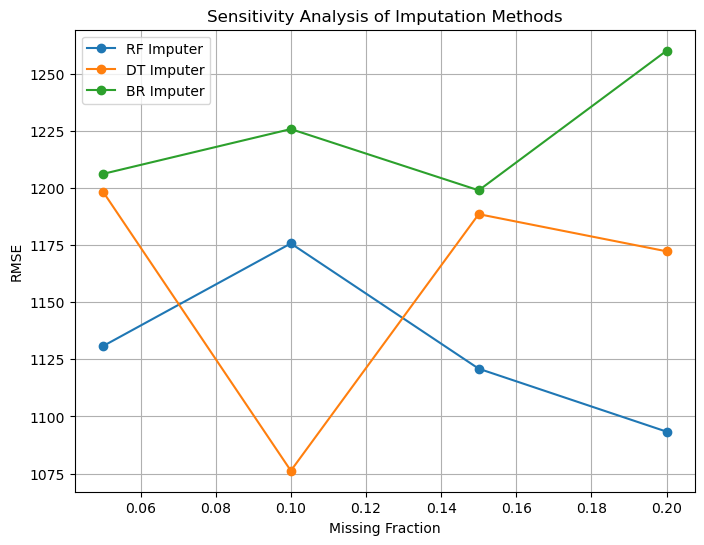

In [47]:
# %% [code]
missing_fracs = [0.05, 0.1, 0.15, 0.2]
rmse_rf_list = []
rmse_dt_list = []
rmse_br_list = []

for frac in missing_fracs:
    rmse_rf_list.append(evaluate_imputer(imputer_rf, complete_train_numeric, missing_frac=frac))
    rmse_dt_list.append(evaluate_imputer(imputer_dt, complete_train_numeric, missing_frac=frac))
    rmse_br_list.append(evaluate_imputer(imputer_br, complete_train_numeric, missing_frac=frac))

plt.figure(figsize=(8, 6))
plt.plot(missing_fracs, rmse_rf_list, marker='o', label="RF Imputer")
plt.plot(missing_fracs, rmse_dt_list, marker='o', label="DT Imputer")
plt.plot(missing_fracs, rmse_br_list, marker='o', label="BR Imputer")
plt.xlabel("Missing Fraction")
plt.ylabel("RMSE")
plt.title("Sensitivity Analysis of Imputation Methods")
plt.legend()
plt.grid(True)
plt.show()


### Additional Part A16: Save Tuned Model Parameters

**Purpose:**  
- Save the best hyperparameters for the tuned models (RandomForest and DecisionTree) to a JSON file.
- This aids in reproducibility and future reference.

Storing these parameters documents your optimized model settings.


In [49]:
# %% [code]
import json

tuned_params = {
    "RandomForestRegressor": rf_grid.best_params_,
    "DecisionTreeRegressor": dt_grid.best_params_
}

with open("tuned_model_params.json", "w") as f:
    json.dump(tuned_params, f, indent=4)

print("Tuned model parameters saved to 'tuned_model_params.json'.")


Tuned model parameters saved to 'tuned_model_params.json'.


### Additional Part A17: Missing Data Patterns for Each Group

**Purpose:**  
- Visualize missing data patterns separately for Group A, Group B, and Group C using the `missingno` library.
- Compare missingness across groups.

This helps you understand group-specific data quality issues.


Missing Data Pattern for Group A:


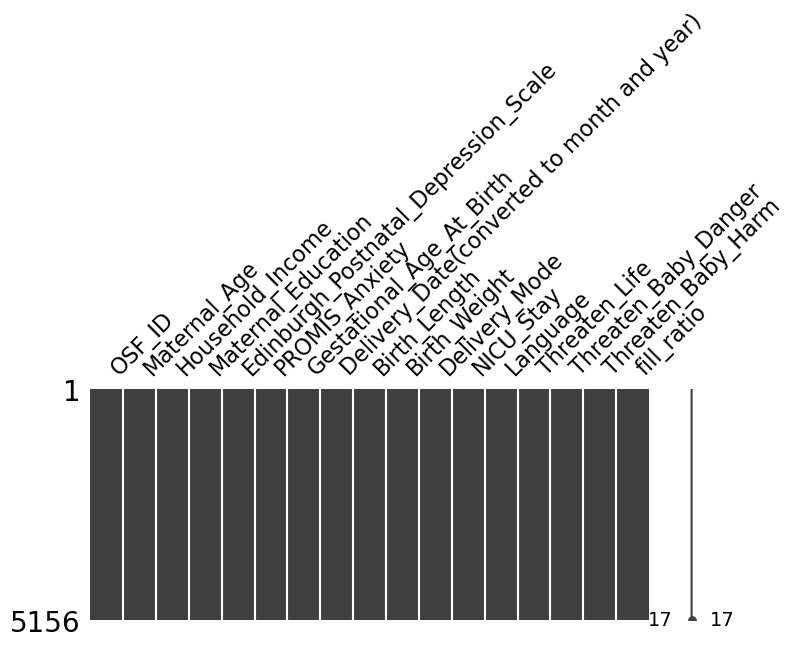

Missing Data Pattern for Group B:


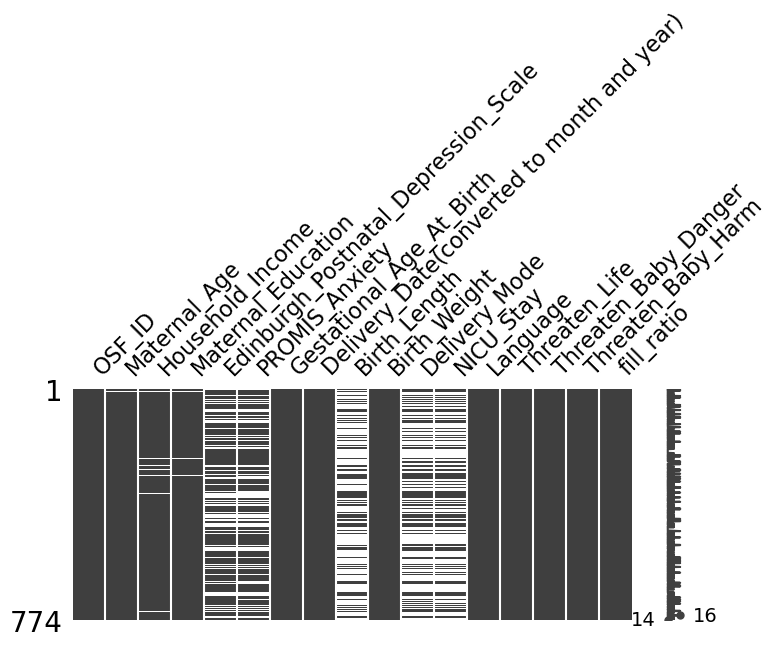

Missing Data Pattern for Group C:


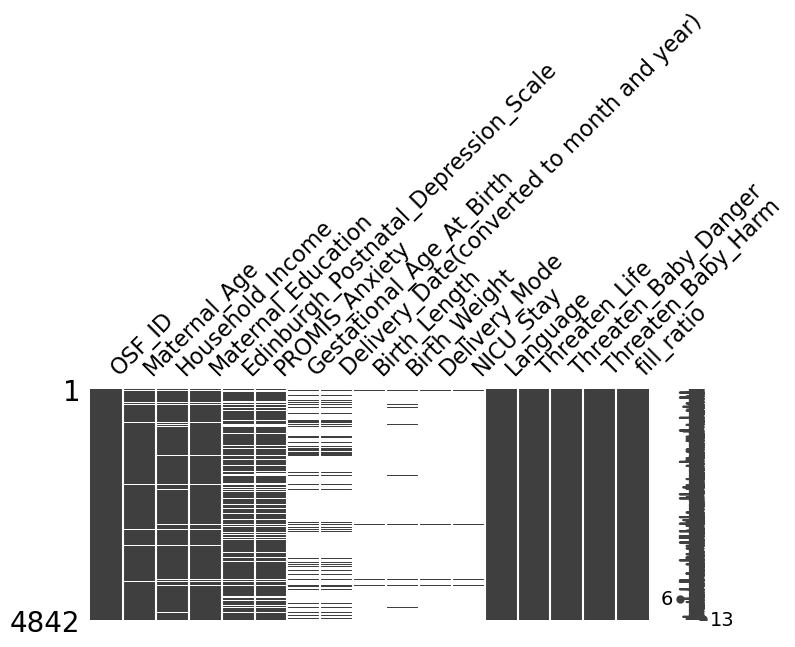

In [50]:
# %% [code]
try:
    import missingno as msno
except ImportError:
    print("missingno not installed. Run: pip install missingno")

print("Missing Data Pattern for Group A:")
msno.matrix(group_A, figsize=(8, 3))
plt.show()

print("Missing Data Pattern for Group B:")
msno.matrix(group_B, figsize=(8, 3))
plt.show()

print("Missing Data Pattern for Group C:")
msno.matrix(group_C, figsize=(8, 3))
plt.show()


### Additional Part A18: Outlier Analysis Before and After Imputation

**Purpose:**  
- Compare the distribution of a key numeric feature before and after imputation using boxplots.
- Assess whether imputation significantly altered the distribution.

This visual comparison helps determine the impact of imputation on extreme values.


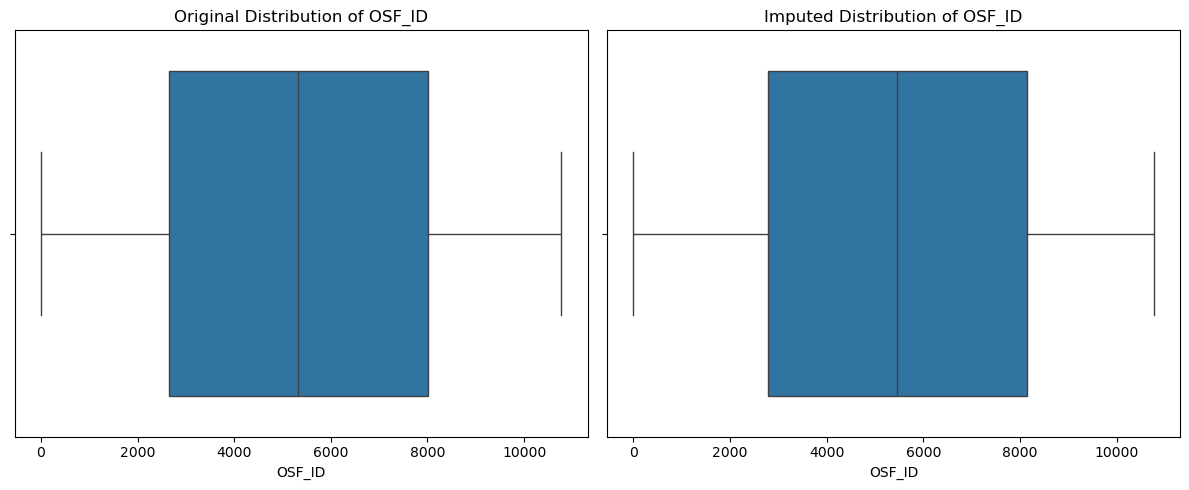

In [51]:
# %% [code]
if num_cols:
    col_example = num_cols[0]
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[col_example])
    plt.title(f"Original Distribution of {col_example}")
    
    plt.subplot(1, 2, 2)
    if not final_complete_df.empty:
        sns.boxplot(x=final_complete_df[col_example])
        plt.title(f"Imputed Distribution of {col_example}")
    else:
        plt.text(0.5, 0.5, "No imputed data", horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns available for outlier analysis.")


### Additional Part A19: Distribution Comparison Before and After Imputation

**Purpose:**  
- Plot histograms to compare the distribution of a selected numeric feature before imputation and after imputation.
- Ensure that the imputation process does not overly distort the original distribution.

This visual check validates the integrity of the imputed data.


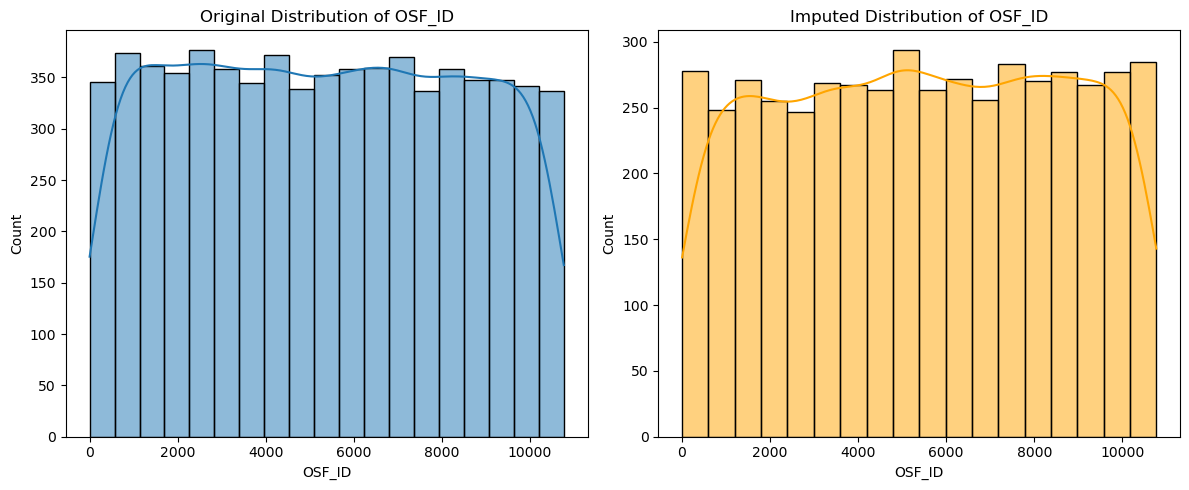

In [52]:
# %% [code]
if num_cols:
    col_example = num_cols[0]
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[col_example].dropna(), kde=True)
    plt.title(f"Original Distribution of {col_example}")
    
    plt.subplot(1, 2, 2)
    if not final_complete_df.empty:
        sns.histplot(final_complete_df[col_example].dropna(), kde=True, color='orange')
        plt.title(f"Imputed Distribution of {col_example}")
    else:
        plt.text(0.5, 0.5, "No imputed data", horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns available for distribution comparison.")


### Additional Part A20: Timing Analysis of the Imputation Process

**Purpose:**  
- Measure and report the time taken for the imputation process on Group C.
- Understanding computational cost helps with optimization and scalability.

This provides insight into the efficiency of your imputation step.


In [53]:
# %% [code]
import time

start_time = time.time()

if impute_numeric.shape[0] != 0:
    imputed_rf_temp = imputer_rf.transform(impute_numeric)
    imputed_dt_temp = imputer_dt.transform(impute_numeric)
    imputed_br_temp = imputer_br.transform(impute_numeric)
    
    temp_ensemble = (w_rf * imputed_rf_temp) + (w_dt * imputed_dt_temp) + (w_br * imputed_br_temp)
    temp_df = pd.DataFrame(temp_ensemble, columns=impute_numeric.columns, index=impute_data.index)
    print("Imputation process completed.")
else:
    print("No numeric incomplete data to impute.")

end_time = time.time()
print(f"Time taken for imputation: {end_time - start_time:.2f} seconds")


Imputation process completed.
Time taken for imputation: 0.55 seconds


### Final Summary of Analysis

**Purpose:**  
This section provides a final overview of the data after processing and imputation. It summarizes key metrics and outputs, including:
- The shape and summary statistics of the final imputed dataset.
- Missing value counts for each column.
- A correlation matrix of numeric features.
- A sample of the final dataset.

This summary consolidates the insights and results from the entire analysis pipeline.


=== FINAL SUMMARY OF ANALYSIS ===

Final complete imputed dataset shape: (4842, 16)

Summary Statistics for Final Dataset:


,OSF_ID,Maternal_Age,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Birth_Length,Birth_Weight
count,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000
mean,5446.884758,31.055453,11.004567,19.406816,39.404154,50.296209,3372.957522
std,3117.726051,4.559660,5.190123,5.720582,0.637599,1.114765,162.185112
min,2.000000,17.000000,0.000000,7.000000,29.140000,30.480000,800.000000
25%,2789.750000,28.100000,8.000000,16.000000,39.327373,50.082292,3325.533335
50%,5447.500000,31.100000,11.000000,20.000000,39.392556,50.230709,3359.945368
75%,8138.500000,34.000000,14.000000,23.000000,39.564748,50.934829,3447.510361
max,10771.000000,49.700000,30.000000,35.000000,42.570000,58.000000,5302.000000



Missing Values in Final Dataset:


OSF_ID                                        0
Maternal_Age                                  0
Household_Income                              0
Maternal_Education                            0
Edinburgh_Postnatal_Depression_Scale          0
PROMIS_Anxiety                                0
Gestational_Age_At_Birth                      0
Delivery_Date(converted to month and year)    0
Birth_Length                                  0
Birth_Weight                                  0
Delivery_Mode                                 0
NICU_Stay                                     0
Language                                      0
Threaten_Life                                 0
Threaten_Baby_Danger                          0
Threaten_Baby_Harm                            0
dtype: int64

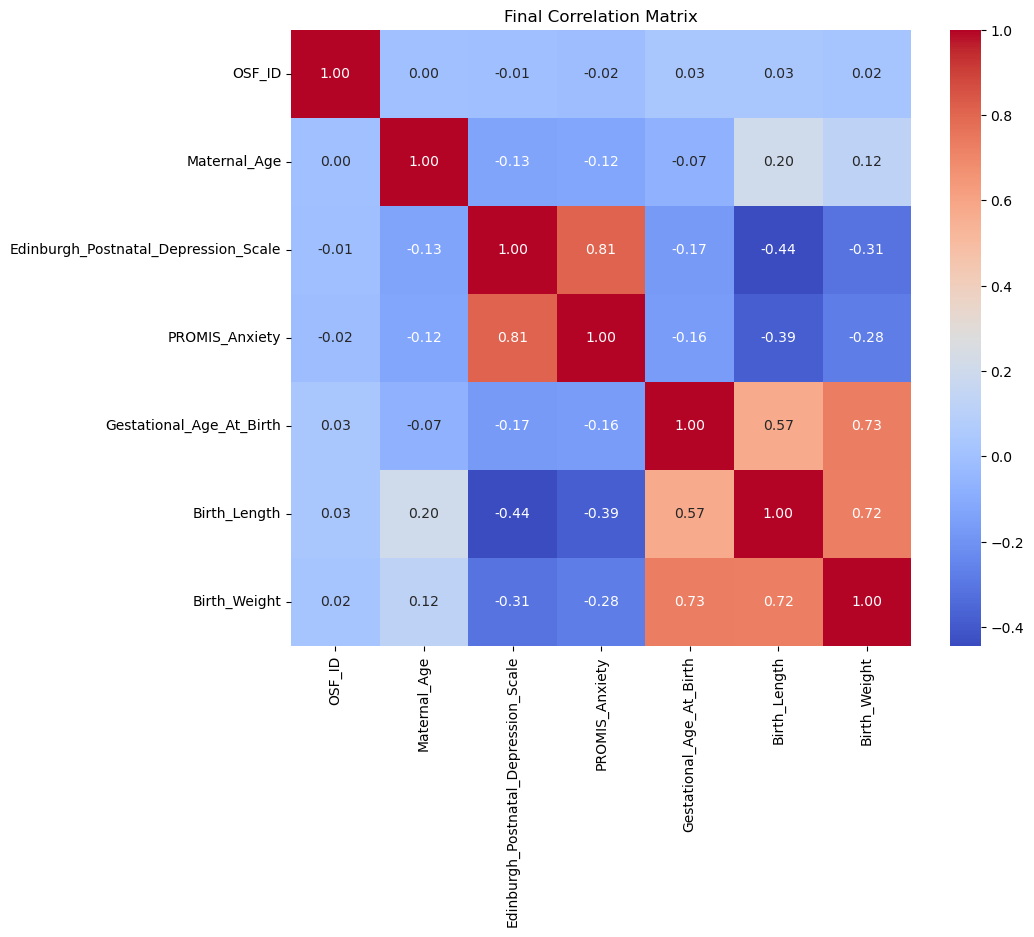


A sample of the final complete imputed dataset:


,OSF_ID,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date(converted to month and year),Birth_Length,Birth_Weight,Delivery_Mode,NICU_Stay,Language,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm
1,2.0,34.600000,"$200,000+",Undergraduate degree,4.000000,17.000000,38.682663,Aug-20,46.715818,2867.906343,Vaginally,No,English,2,33,92
2,3.0,34.300000,"$100,000 -$124,999",Undergraduate degree,12.770631,21.814351,38.845677,Aug-20,49.998286,2999.116851,Vaginally,No,French,,,
5,6.0,38.300000,"$150,000 - $174,999",Undergraduate degree,3.000000,8.000000,38.570000,Jun-20,47.146645,2849.982214,Vaginally,No,English,29,36,33
6,7.0,34.500000,"$200,000+",High school diploma,8.000000,15.000000,39.057111,Aug-20,49.041950,3035.329992,Vaginally,No,English,24,30,32
7,8.0,33.892117,"$70,000-$99,999",Undergraduate degree,10.201251,18.963697,38.000000,May-21,50.170000,2892.000000,Caesarean-section (c-section),Yes,English,,,



All key outputs have been generated. Your analysis is complete!


In [54]:
# %% [code]
print("=== FINAL SUMMARY OF ANALYSIS ===\n")

# Check if the final complete dataset from Group C exists
if 'final_complete_df' in globals() and not final_complete_df.empty:
    # Print dataset shape and summary statistics
    print("Final complete imputed dataset shape:", final_complete_df.shape)
    print("\nSummary Statistics for Final Dataset:")
    display(final_complete_df.describe())
    
    # Display missing values count for each column
    print("\nMissing Values in Final Dataset:")
    missing_counts = final_complete_df.isnull().sum()
    display(missing_counts)
    
    # Generate and display the correlation matrix for numeric features
    final_numeric = final_complete_df.select_dtypes(include=[np.number])
    if not final_numeric.empty:
        corr_final = final_numeric.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_final, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title("Final Correlation Matrix")
        plt.show()
    else:
        print("No numeric columns in the final dataset to compute correlation.")
    
    # Show a sample of the final imputed dataset
    print("\nA sample of the final complete imputed dataset:")
    display(final_complete_df.head())
    
    print("\nAll key outputs have been generated. Your analysis is complete!")
else:
    print("Final complete dataset is not available. Please check earlier steps.")
